In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load stuff into DataFrames

In [260]:
data_folder = "round-4-island-data-bottle/"

price_files = [
    # "prices_round_4_day_1.csv",
    # "prices_round_4_day_2.csv",
    "prices_round_4_day_3.csv",
]

trade_files = [
    # "trades_round_4_day_1.csv",
    # "trades_round_4_day_2.csv",
    "trades_round_4_day_3.csv",
]

observation_files = [
    # "observations_round_4_day_1.csv",
    # "observations_round_4_day_2.csv",
    "observations_round_4_day_3.csv",
]

prices = pd.concat([
    pd.read_csv(data_folder + file, sep=';') for file in price_files
])

trades = pd.concat([
    pd.read_csv(data_folder + file, sep=';') for file in trade_files
])

observations = pd.concat([
    pd.read_csv(data_folder + file, sep=',') for file in observation_files
])

In [261]:
macaron_prices = prices[prices['product'] == "MAGNIFICENT_MACARONS"]
macaron_prices = macaron_prices.fillna(0)
macaron_prices.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
6,3,0,MAGNIFICENT_MACARONS,667.0,14.0,665.0,14.0,658.0,25.0,676,7,685.0,25.0,692.0,14.0,671.5,0.0
20,3,100,MAGNIFICENT_MACARONS,668.0,16.0,666.0,10.0,659.0,28.0,677,8,686.0,28.0,693.0,10.0,672.5,0.0
42,3,200,MAGNIFICENT_MACARONS,665.0,14.0,662.0,14.0,656.0,20.0,674,7,683.0,20.0,689.0,14.0,669.5,0.0
52,3,300,MAGNIFICENT_MACARONS,665.0,16.0,662.0,19.0,656.0,20.0,674,8,683.0,20.0,689.0,19.0,669.5,0.0
60,3,400,MAGNIFICENT_MACARONS,664.0,18.0,662.0,19.0,655.0,30.0,673,9,682.0,30.0,689.0,19.0,668.5,0.0


In [262]:
observations = observations.fillna(0)
observations.head()

,timestamp,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex
0,0,671.0,672.5,2.1,10.0,-3.0,199.000000,55.00
1,100,672.0,673.5,2.1,10.0,-3.0,199.064089,55.00
2,200,668.5,670.0,2.1,10.0,-3.0,198.783168,55.01
3,300,668.5,670.0,2.1,10.0,-3.0,198.545120,55.02
4,400,668.0,669.5,2.1,10.0,-3.0,198.455261,55.02


### Can I profit from import/exports?

In [263]:
aggregate_df = pd.DataFrame()

aggregate_df['best_bid'] = [
    max(macaron_prices[f'bid_price_{i}'].iloc[j] for i in range(1, 4))
    for j in range(len(macaron_prices))
]

aggregate_df['best_ask'] = [
    min(macaron_prices[f'ask_price_{i}'].iloc[j] for i in range(1, 4))
    for j in range(len(macaron_prices))
]

aggregate_df['ext_buy_price'] = observations['askPrice'] + observations['importTariff'] + observations['transportFees']
aggregate_df['ext_sell_price'] = observations['bidPrice'] - observations['exportTariff'] - observations['transportFees']

aggregate_df.head()

,best_bid,best_ask,ext_buy_price,ext_sell_price
0,667.0,676,671.6,658.9
1,668.0,677,672.6,659.9
2,665.0,674,669.1,656.4
3,665.0,674,669.1,656.4
4,664.0,673,668.6,655.9


<Axes: >

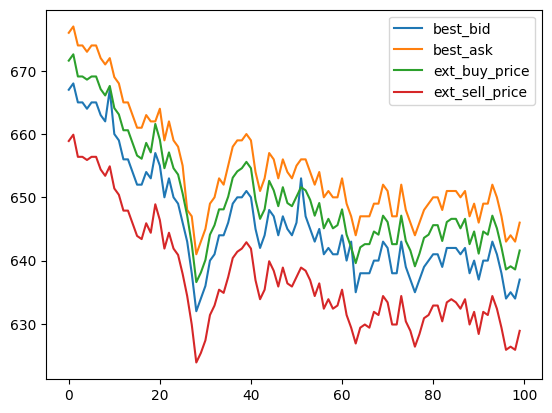

In [264]:
aggregate_df.iloc[:100].plot()

In [265]:
sell_here_buy_there = aggregate_df[aggregate_df['best_bid'] > aggregate_df['ext_buy_price']]

profit_potential = (sell_here_buy_there['best_bid'] - sell_here_buy_there['ext_buy_price']).sum()

days = len(sell_here_buy_there)

print(
    'SELL here, BUY there \n'
    f'Profit potential {profit_potential}, {days} days'
)

SELL here, BUY there 
Profit potential 757.3, 315 days


In [266]:
buy_here_sell_there = aggregate_df[aggregate_df['best_ask'] < aggregate_df['ext_sell_price']]

profit_potential = (buy_here_sell_there['ext_sell_price'] - buy_here_sell_there['best_ask']).sum()

days = len(buy_here_sell_there)

print(
    'BUY here, SELL there \n'
    f'Profit potential {profit_potential}, {days} days'
)

BUY here, SELL there 
Profit potential 0.0, 0 days


In [267]:
cycle_back = aggregate_df[aggregate_df['ext_sell_price'] > aggregate_df['ext_buy_price']]
len(cycle_back)

0

Conclusion: Not very much.  
But importing is always cheaper than buying. That might be useful.

### Can sunlight or whatever predict macaron prices?

In [268]:
from sklearn.model_selection import train_test_split

X = np.array([
    observations[observations.columns[1:]].iloc[i - 100: i - 95].stack()
    for i in range(100, len(observations))
])

y = np.array([
    macaron_prices['mid_price'].iloc[i]
    for i in range(100, len(observations))
])

X_train, X_test, y_train, y_test = X[:8000], X[8000:], y[:8000], y[8000:]

In [269]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [270]:
pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, pred)

40.465789882650085

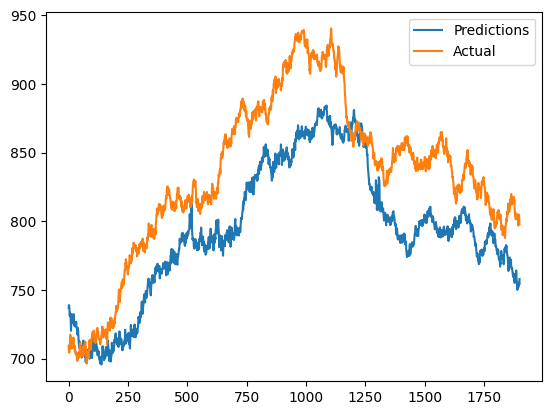

In [271]:
plt.plot(pred, label="Predictions")
plt.plot(y_test, label="Actual")
plt.legend()

I guess not.